<a href="https://colab.research.google.com/github/693080593/research/blob/master/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost
 * object: 
    * Predict ETF closed price in next day using XGBoost
    * Given prices for the last N days, we do prediction for day N+1
    * Find the best N to predict the adjusted close price
    * Get the prediction precision based the rule RMSE and MAPE

In [ ]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

# Ignore useless warnings
import warnings
warnings.filterwarnings("ignore")

#### Input params ##################
path = "/content/SPY.csv"
test_size = 0.2  # proportion of dataset to be used as test set
cv_size = 0.2  # proportion of dataset to be used as cross-validation set
N = 3  # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100  # Number of boosted trees to fit. default = 100
max_depth = 3  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1  # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1  # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1  # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1  # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0  # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

## Functions for XGBoost algorithm

In [ ]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(
        window=N, min_periods=1).mean()  # len(mean_list) = len(df)
    std_list = df[col].rolling(
        window=N, min_periods=1).std(
        )  # first value will be NaN, because normalized by N-1

    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))

    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list

    return df_out


def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days),
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std

    row_scaled = (row - feat_mean) / feat_std

    return row_scaled


def get_mape(y_true, y_pred):
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(
        seed=model_seed,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        gamma=gamma)

    # Train the model
    model.fit(X_train_scaled, y_train_scaled)

    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)

    return rmse, mape, est

# Load data

In [ ]:
df = pd.read_csv(path, sep=",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2014-03-31,186.669998,187.300003,185.520004,187.009995,169.368149,99745000,3
1,2014-04-01,187.619995,188.360001,187.000000,188.250000,170.491180,89193000,4
2,2014-04-02,188.490005,189.130005,188.139999,188.880005,171.061722,78774000,4
3,2014-04-03,189.169998,189.220001,188.050003,188.630005,170.835327,77435000,4
4,2014-04-04,189.660004,189.699997,186.100006,186.399994,168.815704,169381000,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1259 non-null   datetime64[ns]
 1   open       1259 non-null   float64       
 2   high       1259 non-null   float64       
 3   low        1259 non-null   float64       
 4   close      1259 non-null   float64       
 5   adj_close  1259 non-null   float64       
 6   volume     1259 non-null   int64         
 7   month      1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 88.5 KB


In [ ]:
df.describe()

,open,high,low,close,adj_close,volume,month
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,229.749452,230.744519,228.618133,229.761771,219.240476,9.904178e+07,6.540111
std,31.225691,31.319175,31.100454,31.192640,35.836418,4.879860e+07,3.422864
min,182.139999,183.369995,181.020004,181.509995,164.387024,2.785650e+07,1.000000
25%,204.849998,206.100006,203.959999,204.994996,189.990547,6.653075e+07,4.000000
50%,216.529999,217.119995,215.750000,216.589996,205.805191,8.627080e+07,7.000000
75%,259.970001,261.029999,258.044998,259.794999,255.438476,1.169876e+08,10.000000
max,293.089996,293.940002,291.809998,293.579987,289.286011,5.072443e+08,12.000000


Text(0, 0.5, 'USD')

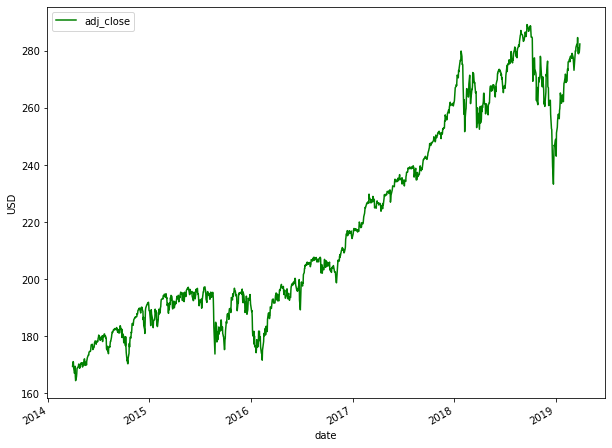

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='g-')
ax.set_xlabel("date")
ax.set_ylabel("USD")

## Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [ ]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2014-03-31,169.368149,99745000,3,1.779999,-0.339997
1,2014-04-01,170.491180,89193000,4,1.360001,-0.630005
2,2014-04-02,171.061722,78774000,4,0.990006,-0.390000
3,2014-04-03,170.835327,77435000,4,1.169998,0.539993
4,2014-04-04,168.815704,169381000,4,3.599991,3.260010


Now we use lags up to N number of days to use as features.

In [ ]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [ ]:
shift_range = [x + 1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()

    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift

    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left')  #.fillna(0)

del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]

df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2014-04-03,170.835327,77435000,4,1.169998,0.539993,3,171.061722,0.990006,-0.390000,78774000.0,170.491180,1.360001,-0.630005,89193000.0,169.368149,1.779999,-0.339997,99745000.0
4,2014-04-04,168.815704,169381000,4,3.599991,3.260010,4,170.835327,1.169998,0.539993,77435000.0,171.061722,0.990006,-0.390000,78774000.0,170.491180,1.360001,-0.630005,89193000.0
5,2014-04-07,166.950043,140803000,4,2.299988,1.610001,5,168.815704,3.599991,3.260010,169381000.0,170.835327,1.169998,0.539993,77435000.0,171.061722,0.990006,-0.390000,78774000.0
6,2014-04-08,167.638336,112660000,4,1.809998,-0.840011,6,166.950043,2.299988,1.610001,140803000.0,168.815704,3.599991,3.260010,169381000.0,170.835327,1.169998,0.539993,77435000.0
7,2014-04-09,169.440613,100254000,4,2.089996,-1.489990,7,167.638336,1.809998,-0.840011,112660000.0,166.950043,2.299988,1.610001,140803000.0,168.815704,3.599991,3.260010,169381000.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1256 entries, 3 to 1258
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1256 non-null   datetime64[ns]
 1   adj_close        1256 non-null   float64       
 2   volume           1256 non-null   int64         
 3   month            1256 non-null   int64         
 4   range_hl         1256 non-null   float64       
 5   range_oc         1256 non-null   float64       
 6   order_day        1256 non-null   int64         
 7   adj_close_lag_1  1256 non-null   float64       
 8   range_hl_lag_1   1256 non-null   float64       
 9   range_oc_lag_1   1256 non-null   float64       
 10  volume_lag_1     1256 non-null   float64       
 11  adj_close_lag_2  1256 non-null   float64       
 12  range_hl_lag_2   1256 non-null   float64       
 13  range_oc_lag_2   1256 non-null   float64       
 14  volume_lag_2     1256 non-null   float64

In [ ]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb,
#               left_on=['month'],
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()

#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift

#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)

# del train_shift

# df

In [ ]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

## Get mean and standard deviation at timestamp t using values from t-1, ..., t-N

In [ ]:
cols_list = ["adj_close", "range_hl", "range_oc", "volume"]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2014-04-03,170.835327,77435000,4,1.169998,0.539993,3,171.061722,0.990006,-0.390000,78774000.0,170.491180,1.360001,-0.630005,89193000.0,169.368149,1.779999,-0.339997,99745000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-04-04,168.815704,169381000,4,3.599991,3.260010,4,170.835327,1.169998,0.539993,77435000.0,171.061722,0.990006,-0.390000,78774000.0,170.491180,1.360001,-0.630005,89193000.0,170.835327,NaN,1.169998,NaN,0.539993,NaN,7.743500e+07,NaN
5,2014-04-07,166.950043,140803000,4,2.299988,1.610001,5,168.815704,3.599991,3.260010,169381000.0,170.835327,1.169998,0.539993,77435000.0,171.061722,0.990006,-0.390000,78774000.0,169.825515,1.428089,2.384994,1.718265,1.900002,1.923342,1.234080e+08,6.501564e+07
6,2014-04-08,167.638336,112660000,4,1.809998,-0.840011,6,166.950043,2.299988,1.610001,140803000.0,168.815704,3.599991,3.260010,169381000.0,170.835327,1.169998,0.539993,77435000.0,168.867025,1.943150,2.356659,1.215987,1.803335,1.370276,1.292063e+08,4.705719e+07
7,2014-04-09,169.440613,100254000,4,2.089996,-1.489990,7,167.638336,1.809998,-0.840011,112660000.0,166.950043,2.299988,1.610001,140803000.0,168.815704,3.599991,3.260010,169381000.0,167.801361,0.943454,2.569992,0.925038,1.343333,2.062978,1.409480e+08,2.836078e+07


## Split into training, validation and test set

In [ ]:
# Get sizes of each of the datasets
num_cv = int(cv_size * len(df))
num_test = int(test_size * len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train + num_cv]
train_cv = df[:num_train + num_cv]
test = df[num_train + num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 754
num_cv = 251
num_test = 251
train.shape = (754, 27)
cv.shape = (251, 27)
train_cv.shape = (1005, 27)
test.shape = (251, 27)


## Scaling the training, validation and test set

In [ ]:
cols_to_scale = ["adj_close"]

for i in range(1, N + 1):
    cols_to_scale.append("adj_close_lag_" + str(i))
    cols_to_scale.append("range_hl_lag_" + str(i))
    cols_to_scale.append("range_oc_lag_" + str(i))
    cols_to_scale.append("volume_lag_" + str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 1.92968981e+02  1.92894194e+02  1.90119333e+00 -4.46950557e-02
  1.08749486e+08  1.92819608e+02  1.90156468e+00 -4.48011790e-02
  1.08785617e+08  1.92743814e+02  1.90038431e+00 -4.25332666e-02
  1.08793920e+08]
scaler.var_ = [1.90403202e+02 1.89457191e+02 1.43115931e+00 1.74861690e+00
 2.61686574e+15 1.88598979e+02 1.43065325e+00 1.74873262e+00
 2.61446696e+15 1.87816635e+02 1.42988831e+00 1.74351038e+00
 2.61426475e+15]
train_scaled.shape = (754, 13)
train_scaled.shape = (754, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.604043,-1.586161,-0.761664,-0.261129,-0.585970,-1.625880,-0.452775,-0.442533,-0.383178,-1.705678,-0.100675,-0.225280,-0.176979,2014-04-03,4
1,-1.750407,-1.602609,-0.611209,0.442157,-0.612145,-1.584335,-0.762110,-0.261040,-0.586946,-1.623732,-0.451909,-0.444913,-0.383355,2014-04-04,4
2,-1.885612,-1.749338,1.420030,2.499110,1.185244,-1.600820,-0.611627,0.442223,-0.613133,-1.582101,-0.761326,-0.263149,-0.587131,2014-04-07,4
3,-1.835731,-1.884881,0.333354,1.251327,0.626592,-1.747882,1.419971,2.499108,1.185081,-1.598620,-0.610804,0.441167,-0.613319,2014-04-08,4
4,-1.705119,-1.834875,-0.076230,-0.601440,0.076444,-1.883734,0.333102,1.251366,0.626173,-1.745988,1.421338,2.501130,1.184964,2014-04-09,4


In [ ]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 2.06490944e+02  2.06404297e+02  1.89882593e+00 -1.87063423e-02
  1.01635188e+08  2.06320323e+02  1.89613934e+00 -2.02486488e-02
  1.01578214e+08  2.06234480e+02  1.89001994e+00 -2.61292498e-02
  1.01548168e+08]
scaler_train_cv.var_ = [7.44574966e+02 7.43161891e+02 1.84627144e+00 2.04440867e+00
 2.53080677e+15 7.42099481e+02 1.84190555e+00 2.04390130e+00
 2.52895898e+15 7.41030405e+02 1.80565527e+00 2.01287297e+00
 2.52816096e+15]
train_cv_scaled.shape = (1005, 13)
train_cv_scaled.shape = (1005, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.306694,-1.296452,-0.668852,-0.259677,-0.454432,-1.315241,-0.395042,-0.426507,-0.246282,-1.354291,-0.081876,-0.221227,-0.035862,2014-04-03,4
1,-1.380708,-1.304757,-0.536386,0.390746,-0.481049,-1.294297,-0.667665,-0.258631,-0.453465,-1.313036,-0.394434,-0.425637,-0.245723,2014-04-04,4
2,-1.449080,-1.378842,1.251984,2.293084,1.346644,-1.302608,-0.535042,0.391873,-0.480092,-1.292077,-0.669779,-0.256471,-0.452939,2014-04-07,4
3,-1.423856,-1.447279,0.295238,1.139093,0.778574,-1.376746,1.255446,2.294448,1.348269,-1.300394,-0.535832,0.399027,-0.479570,2014-04-08,4
4,-1.357806,-1.422030,-0.065374,-0.574408,0.219150,-1.445232,0.297567,1.140313,0.779991,-1.374585,1.272540,2.316209,1.349080,2014-04-09,4


In [ ]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N + 1)]
    temp = cv.apply(
        lambda row: scale_row(row[feat_list], row[col + '_mean'], row[col + '_std']),
        axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)

# Now the entire dev set is scaled
cv_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
757,2017-03-31,1.127361,-0.347364,-0.779997,-0.477250,-0.671965,1.149215,0.400218,0.737904,-1.138122,-0.703453,-0.441284,1.144737
758,2017-04-03,-0.300367,1.115758,-0.815391,-1.057121,0.930894,0.126227,1.112875,-0.823143,-0.289732,1.101754,-0.850216,-0.251538
759,2017-04-04,-0.948038,-0.096873,1.044911,1.094306,-0.866326,-0.227980,0.792040,0.331650,-1.123691,0.935015,0.119272,-1.054287
760,2017-04-05,-0.176824,-0.899793,1.076618,-0.435544,1.143907,-0.708363,-1.093999,0.866959,0.227040,-1.056337,0.932042,0.124295
761,2017-04-06,-1.130548,0.768734,0.361814,0.926319,-1.060193,0.133874,1.010046,-0.989642,-0.020404,0.960908,-1.034973,0.074065


In [ ]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N + 1)]
    temp = test.apply(
        lambda row: scale_row(row[feat_list], row[col + '_mean'], row[col + '_std']),
        axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)

# Now the entire test set is scaled
test_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1008,2018-04-02,1.126000,-0.784571,-0.341429,-0.195253,-0.887973,1.083226,-0.917817,-0.147893,1.065710,-1.017026,0.982057,0.034969
1009,2018-04-03,-0.939196,1.051348,-0.112152,1.100843,-0.248579,-0.852264,1.051662,-0.938754,-0.112908,1.021484,-0.977034,-0.044450
1010,2018-04-04,0.107520,-1.049415,0.941895,-0.790061,1.124313,-0.334252,-0.561297,1.154553,-0.593256,-0.472243,1.148667,-0.676424
1011,2018-04-05,0.970947,0.055772,-1.026719,0.405218,-1.139011,0.733793,-0.937246,-0.115481,1.052727,-0.526178,-0.627053,1.153231
1012,2018-04-06,0.948055,0.096843,-1.044898,-0.923414,1.062107,-0.138693,0.817721,-1.114905,0.297184,-1.150737,0.658151,0.492586


## Split into X and y

In [ ]:
features = []
for i in range(1, N + 1):
    features.append("adj_close_lag_" + str(i))
    features.append("range_hl_lag_" + str(i))
    features.append("range_oc_lag_" + str(i))
    features.append("volume_lag_" + str(i))

target = "adj_close"

# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (754, 12)
y_train.shape = (754,)
X_cv.shape = (251, 12)
y_cv.shape = (251,)
X_train_cv.shape = (1005, 12)
y_train_cv.shape = (1005,)
X_sample.shape = (251, 12)
y_sample.shape = (251,)


In [ ]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (754, 12)
y_train_scaled.shape = (754,)
X_cv_scaled.shape = (251, 12)
X_train_cv_scaled.shape = (1005, 12)
y_train_cv_scaled.shape = (1005,)
X_sample_scaled.shape = (251, 12)


## EDA

Text(0.5, 1.0, 'Without scaling')

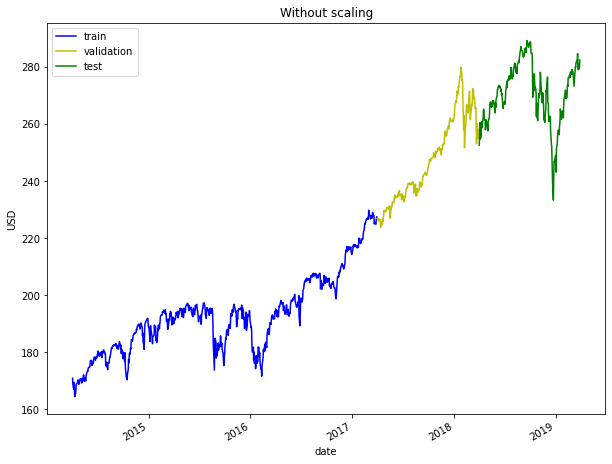

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-')
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

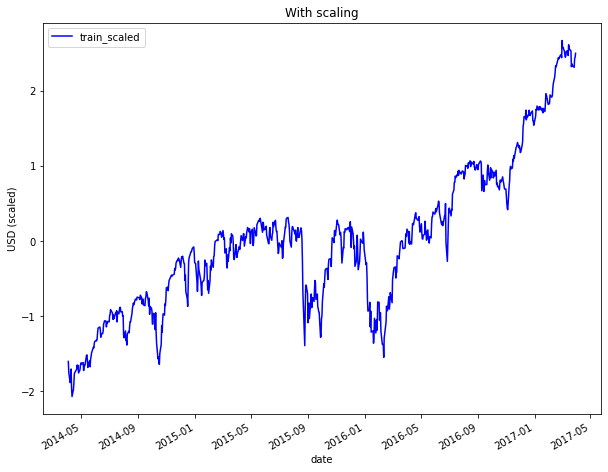

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-')
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

## Train the model using XGBoost

In [ ]:
# Create the model
model = XGBRegressor(
    seed=model_seed,
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    min_child_weight=min_child_weight,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    colsample_bylevel=colsample_bylevel,
    gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

[16:34:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

## Prediction on the training set

In [ ]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print(
    "RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 1.038
MAPE on train set = 0.404%


Text(0.5, 1.0, 'Without scaling')

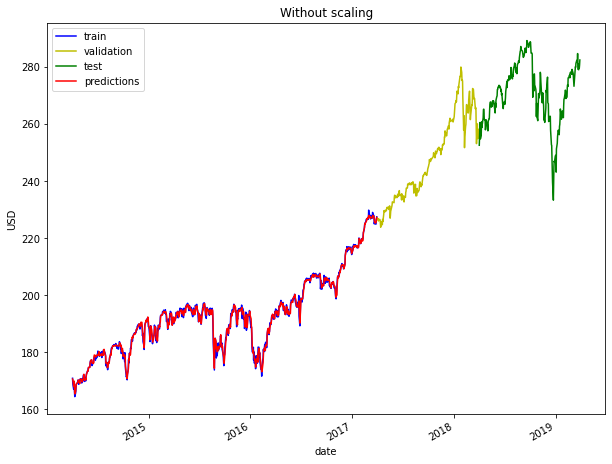

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

est_df = pd.DataFrame({'est': est, 'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-')
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

## Prediction on the validation set

In [ ]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 1.860
MAPE on dev set = 0.444%


Text(0, 0.5, 'USD')

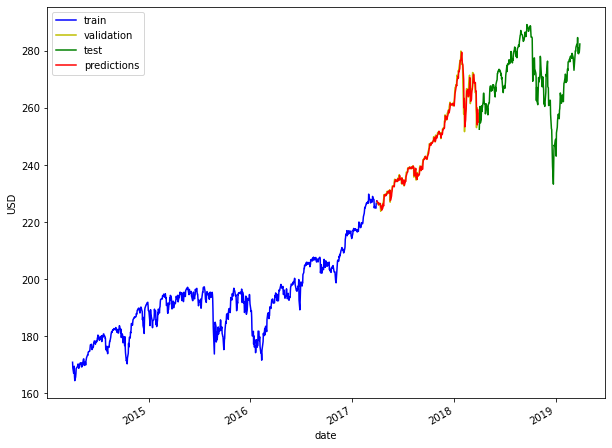

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 'y_cv': y_cv, 'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-')
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to validation set')

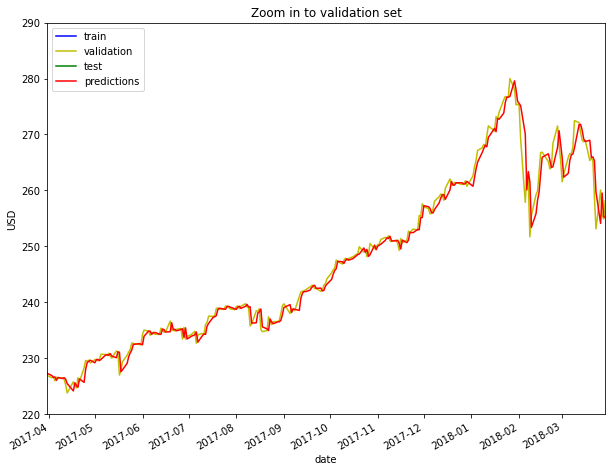

In [ ]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-')
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 3, 31), date(2018, 3, 29)])
ax.set_ylim([220, 290])
ax.set_title("Zoom in to validation set")

The predictions capture the turn in directions with a slight lag

In [ ]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1])
imp[-10:]

[('range_oc_lag_3', 0.0017440724),
 ('volume_lag_2', 0.0017612396),
 ('range_hl_lag_2', 0.0017732743),
 ('volume_lag_3', 0.0017791823),
 ('range_hl_lag_1', 0.0020918602),
 ('range_hl_lag_3', 0.0021919974),
 ('volume_lag_1', 0.0023708344),
 ('adj_close_lag_2', 0.053395778),
 ('adj_close_lag_3', 0.13326791),
 ('adj_close_lag_1', 0.7964985)]

Importance features dominated by adj_close and volume

## Tuning parameters

### Tuning N (number of days to use as features)

In [ ]:
d = {
    'N': [2, 3, 4, 5, 6, 7, 14],
    'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
    'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]
}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,1.225,0.585
1,3,1.214,0.581
2,4,1.231,0.590
3,5,1.249,0.601
4,6,1.254,0.609
5,7,1.251,0.612
6,14,1.498,0.763


Use N = 3 for lowest RMSE and MAPE

### Tuning XGBoost: n_estimators (default=100) and max_depth (default=3)

**parameters**:
* n_estimators = range(10, 310, 10)
* maximum depth = {2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    #     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(
            X_train_scaled,
            y_train_scaled,
            X_cv_scaled,
            y_cv,
            cv['adj_close_mean'],
            cv['adj_close_std'],
            seed=model_seed,
            n_estimators=param,
            max_depth=param2,
            learning_rate=learning_rate,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            colsample_bylevel=colsample_bylevel,
            gamma=gamma)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc - tic) / 60.0))
error_rate

[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,n_estimators,max_depth,rmse,mape_pct
0,10,2,1.894335,0.442457
1,10,3,1.922681,0.450972
2,10,4,1.937894,0.455140
3,10,5,1.906966,0.445226
4,10,6,1.910807,0.445485
...,...,...,...,...
235,300,5,1.851549,0.442741
236,300,6,1.853994,0.447503
237,300,7,1.852093,0.443969
238,300,8,1.872633,0.448620


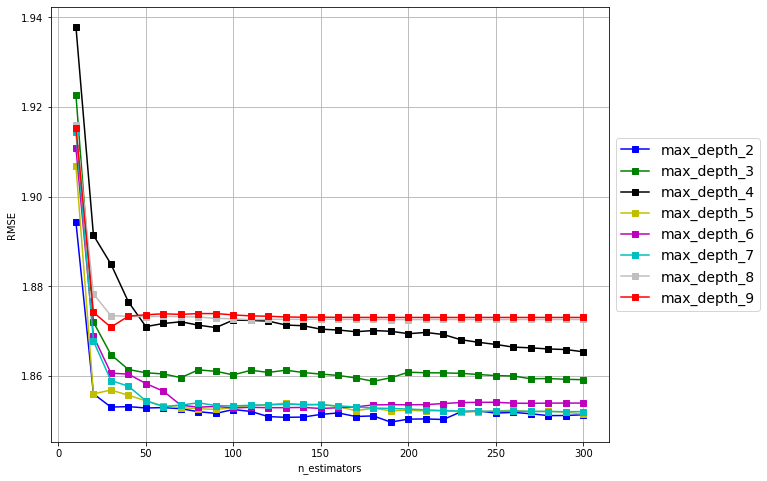

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
temp = error_rate[error_rate[param2_label] == param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1, len(param2_list)):
    temp = error_rate[error_rate[param2_label] == param2_list[i]]
    ax = temp.plot(
        x=param_label,
        y='rmse',
        color=color_list[i % len(color_list)],
        marker='s',
        grid=True,
        ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(
    legend_list, loc='center left',
    bbox_to_anchor=(1.0, 0.5))  # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 1.850
optimum params = 


(190, 2)

In [ ]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 0.439%
optimum params = 


(20, 2)

### Tuning XGBoost: learning_rate(default=0.1) and min_child_weight(default=1)
**parameters**:
* learning rate = {0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3}
* minimum child weight = {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [ ]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    #     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(
            X_train_scaled,
            y_train_scaled,
            X_cv_scaled,
            y_cv,
            cv['adj_close_mean'],
            cv['adj_close_std'],
            seed=model_seed,
            n_estimators=n_estimators_opt,
            max_depth=max_depth_opt,
            learning_rate=param,
            min_child_weight=param2,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            colsample_bylevel=colsample_bylevel,
            gamma=gamma)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc - tic) / 60.0))
error_rate

[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,2.201397,0.506381
1,0.001,6,2.201397,0.506381
2,0.001,7,2.201397,0.506381
3,0.001,8,2.201397,0.506381
4,0.001,9,2.201397,0.506381
...,...,...,...,...
107,0.300,16,1.826731,0.440477
108,0.300,17,1.824843,0.438789
109,0.300,18,1.831223,0.440515
110,0.300,19,1.826231,0.439224


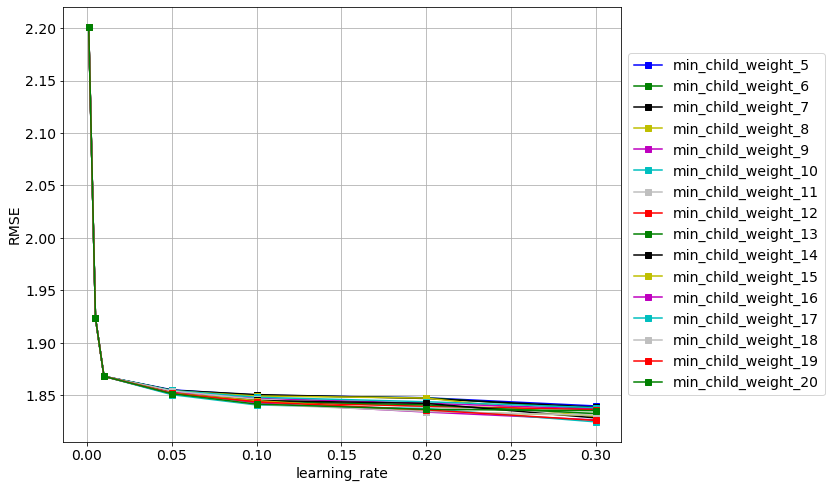

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
temp = error_rate[error_rate[param2_label] == param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1, len(param2_list)):
    temp = error_rate[error_rate[param2_label] == param2_list[i]]
    ax = temp.plot(
        x=param_label,
        y='rmse',
        color=color_list[i % len(color_list)],
        marker='s',
        grid=True,
        ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(
    legend_list, loc='center left',
    bbox_to_anchor=(1.0, 0.5))  # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 1.825
optimum params = 


(0.3, 17)

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 0.438%
optimum params = 


(0.3, 8)

### Tuning XGBoost: subsample(default=1) and gamma(default=0)
**parameters**:
* subsample = {0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1}
* gamma = {0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1}

In [ ]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    #     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(
            X_train_scaled,
            y_train_scaled,
            X_cv_scaled,
            y_cv,
            cv['adj_close_mean'],
            cv['adj_close_std'],
            seed=model_seed,
            n_estimators=n_estimators_opt,
            max_depth=max_depth_opt,
            learning_rate=learning_rate_opt,
            min_child_weight=min_child_weight_opt,
            subsample=param,
            colsample_bytree=colsample_bytree,
            colsample_bylevel=colsample_bylevel,
            gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc - tic) / 60.0))
error_rate

[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,subsample,gamma,rmse,mape_pct
0,0.1,0.1,1.997939,0.471896
1,0.1,0.2,1.888472,0.443777
2,0.1,0.3,1.931990,0.459554
3,0.1,0.4,1.918008,0.452274
4,0.1,0.5,1.907484,0.446018
...,...,...,...,...
95,1.0,0.6,1.858205,0.442647
96,1.0,0.7,1.855382,0.442496
97,1.0,0.8,1.858922,0.442683
98,1.0,0.9,1.858922,0.442683


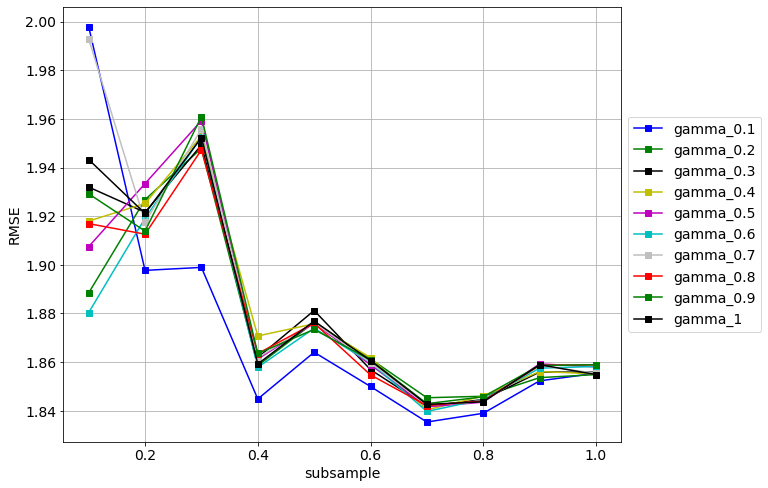

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
temp = error_rate[error_rate[param2_label] == param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1, len(param2_list)):
    temp = error_rate[error_rate[param2_label] == param2_list[i]]
    ax = temp.plot(
        x=param_label,
        y='rmse',
        color=color_list[i % len(color_list)],
        marker='s',
        grid=True,
        ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(
    legend_list, loc='center left',
    bbox_to_anchor=(1.0, 0.5))  # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 1.835
optimum params = 


(0.7, 0.1)

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 0.435%
optimum params = 


(0.1, 0.6)

### Tuning XGBoost: colsample_bytree(default=1) and colsample_bylevel(default=1)
**parameters**:
* colsample by tree = {0.5, 0.6, 0.7, 0.8, 0.9, 1}
* colsample by level = {0.5, 0.6, 0.7, 0.8, 0.9, 1}

In [ ]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    #     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(
            X_train_scaled,
            y_train_scaled,
            X_cv_scaled,
            y_cv,
            cv['adj_close_mean'],
            cv['adj_close_std'],
            seed=model_seed,
            n_estimators=n_estimators_opt,
            max_depth=max_depth_opt,
            learning_rate=learning_rate_opt,
            min_child_weight=min_child_weight_opt,
            subsample=subsample_opt,
            colsample_bytree=param,
            colsample_bylevel=param2,
            gamma=gamma_opt)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc - tic) / 60.0))
error_rate

[16:35:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,1.962319,0.477271
1,0.5,0.6,1.962319,0.477271
2,0.5,0.7,1.929386,0.468734
3,0.5,0.8,1.929386,0.468734
4,0.5,0.9,1.840986,0.434536
5,0.5,1.0,1.832669,0.438266
6,0.6,0.5,1.980517,0.482290
7,0.6,0.6,2.062343,0.492332
8,0.6,0.7,2.062343,0.492332
9,0.6,0.8,1.947074,0.454617


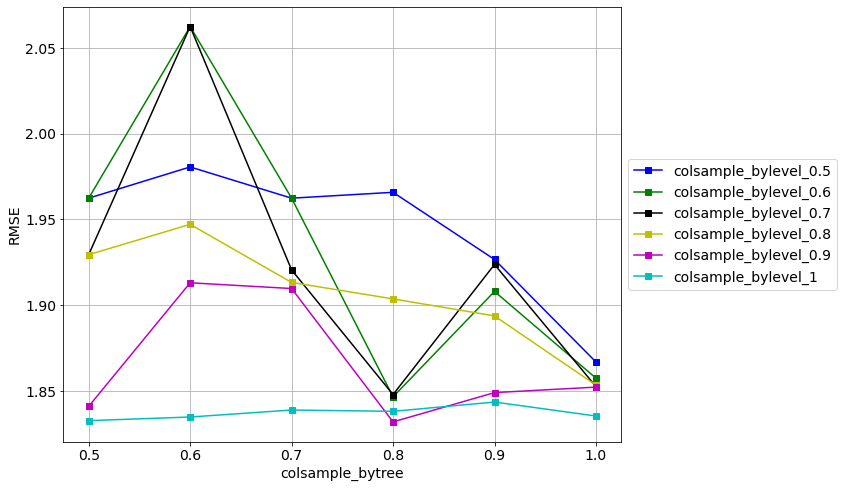

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
temp = error_rate[error_rate[param2_label] == param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1, len(param2_list)):
    temp = error_rate[error_rate[param2_label] == param2_list[i]]
    ax = temp.plot(
        x=param_label,
        y='rmse',
        color=color_list[i % len(color_list)],
        marker='s',
        grid=True,
        ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(
    legend_list, loc='center left',
    bbox_to_anchor=(1.0, 0.5))  # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 1.832
optimum params = 


(0.8, 0.9)

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 0.434%
optimum params = 


(0.9, 0.9)

### Tuned parameters

In [ ]:
d = {
    'param': [
        'n_estimators', 'max_depth', 'learning_rate', 'min_child_weight',
        'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse',
        'mape_pct'
    ],
    'original': [
        n_estimators, max_depth, learning_rate, min_child_weight, subsample,
        colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning,
        mape_bef_tuning
    ],
    'after_tuning': [
        n_estimators_opt, max_depth_opt, learning_rate_opt,
        min_child_weight_opt, subsample_opt, colsample_bytree_opt,
        colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(),
        error_rate['mape_pct'].min()
    ]
}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,190.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.300
3,min_child_weight,1.000,17.000
4,subsample,1.000,0.700
5,colsample_bytree,1.000,0.800
6,colsample_bylevel,1.000,0.900
7,gamma,0.000,0.100
8,rmse,1.860,1.832
9,mape_pct,0.444,0.434


## Final model

In [ ]:
rmse, mape, est = train_pred_eval_model(
    X_train_cv_scaled,
    y_train_cv_scaled,
    X_sample_scaled,
    y_sample,
    test['adj_close_mean'],
    test['adj_close_std'],
    seed=model_seed,
    n_estimators=n_estimators_opt,
    max_depth=max_depth_opt,
    learning_rate=learning_rate_opt,
    min_child_weight=min_child_weight_opt,
    subsample=subsample_opt,
    colsample_bytree=colsample_bytree_opt,
    colsample_bylevel=colsample_bylevel_opt,
    gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

[16:35:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on test set = 2.919
MAPE on test set = 0.809%


Text(0, 0.5, 'USD')

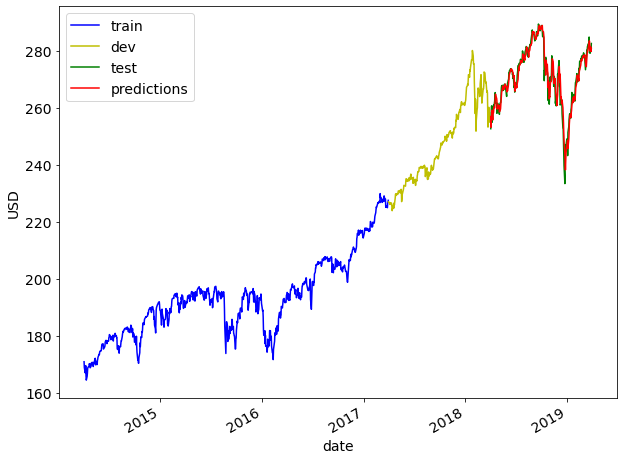

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

est_df = pd.DataFrame({'est': est, 'y_sample': y_sample, 'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-')
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

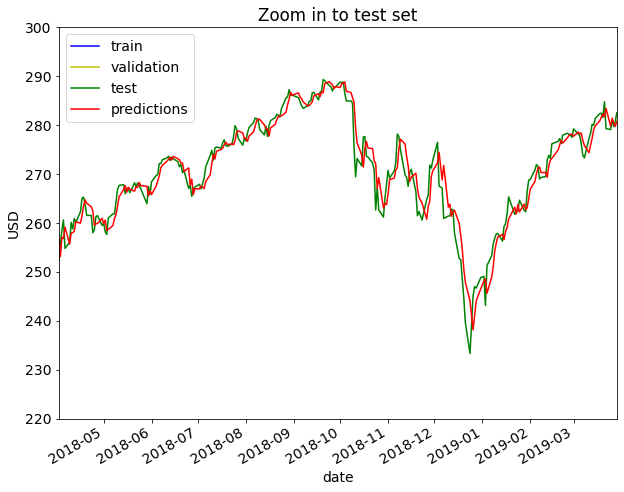

In [ ]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-')
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 2), date(2019, 3, 29)])
ax.set_ylim([220, 300])
ax.set_title("Zoom in to test set")

Similar to validation set, the predictions capture turns in direction with a slight lag

(220.0, 300.0)

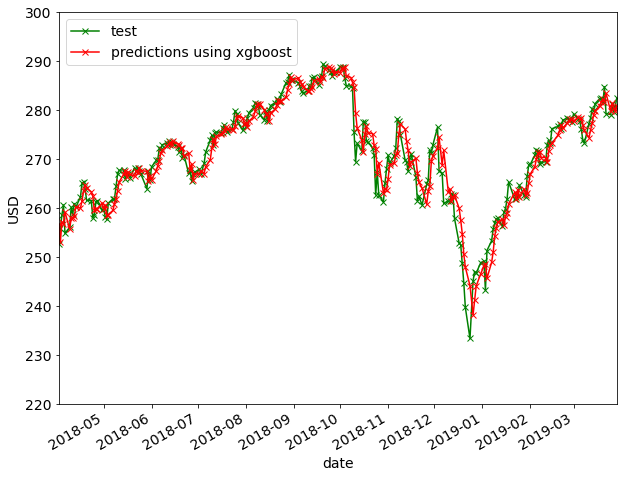

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-')
ax = est_df.plot(x='date', y='est', style='rx-', ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 2), date(2019, 3, 29)])
ax.set_ylim([220, 300])

In [ ]:
# Save as csv
test_xgboost = est_df
test_xgboost.to_csv("/content/test_xgboost.csv")

## Result:
* By scaling the features properly, we can get good results for our predictions
* RMSE and MAPE changed very little with hyperparameter tuning
* The final RMSE and MAPE for test set are 2.581 and 0.688% respectively